In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from utilities import bs_calibrate, bs_results, utils

# DATA PREPRATION

In [4]:
df = pd.read_csv("../dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("../dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [5]:
# HYPERPARAMETER OPTIMIZATION
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'lambda': trial.suggest_float('lambda', 0.0, 5.0),
        'alpha': trial.suggest_float('alpha', 0.0, 5.0)
    }
    xgb_clf = make_pipeline(preprocessor, xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss'))
    cv_roc_auc = cross_val_score(xgb_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
    return cv_roc_auc

In [6]:
storage_name = "sqlite:///db.sqlite3"
# sampler = TPESampler(seed=72)
# # Random seeds - 42,50,58,66,72
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="XGB_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)

In [7]:
storage_name = "sqlite:///db.sqlite3"
loaded_study = optuna.create_study(study_name="XGB_one_day_assessment_final04", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

[I 2024-08-03 13:34:51,693] Using an existing study with name 'XGB_one_day_assessment_final04' instead of creating a new one.


## Bootstraping and Calibration

In [8]:
# For Gradient Boosting
top_models_xgb, results_xgb, calibration_data_xgb = bs_calibrate.bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, xgb.XGBClassifier, best_params
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data 

In [9]:
joblib.dump(top_models_xgb, '../XGBoost_Models/top_models_xgb.joblib')
joblib.dump(results_xgb, '../XGBoost_Models/results.joblib')
joblib.dump(calibration_data_xgb, '../XGBoost_Models/calibration_data_xgb.joblib')

['../XGBoost_Models/calibration_data_xgb.joblib']

## Plotting and calibration curves

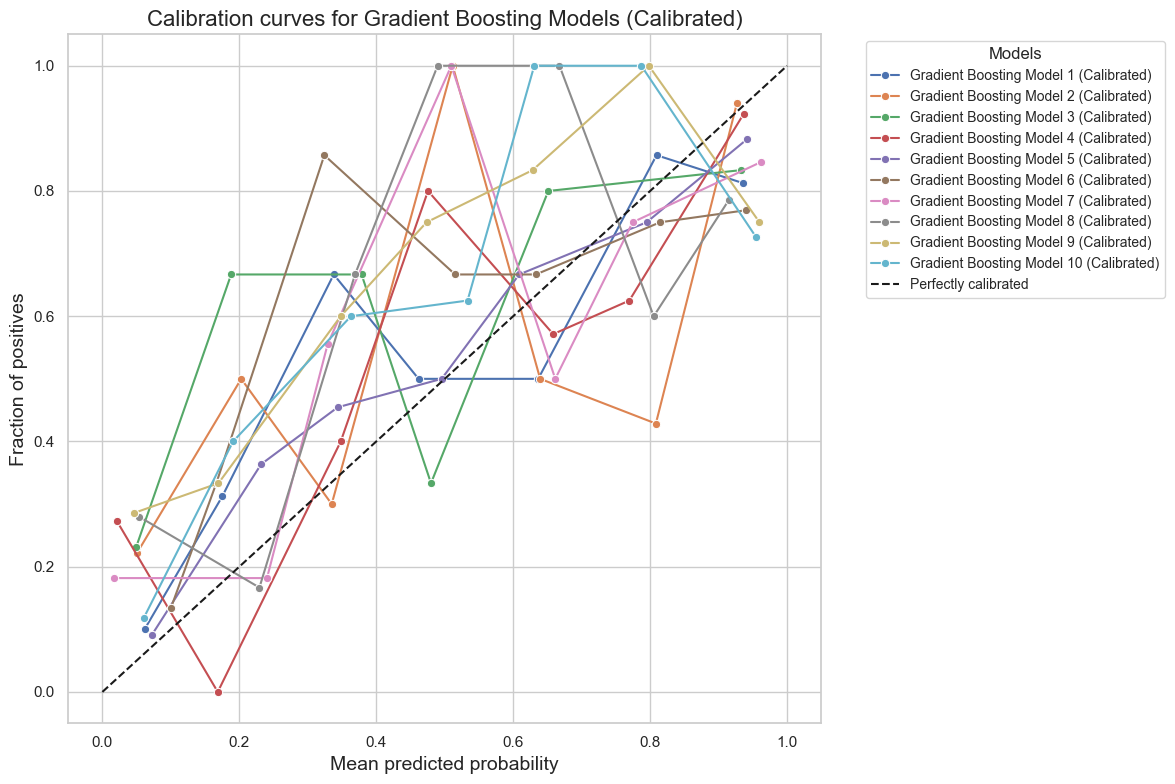

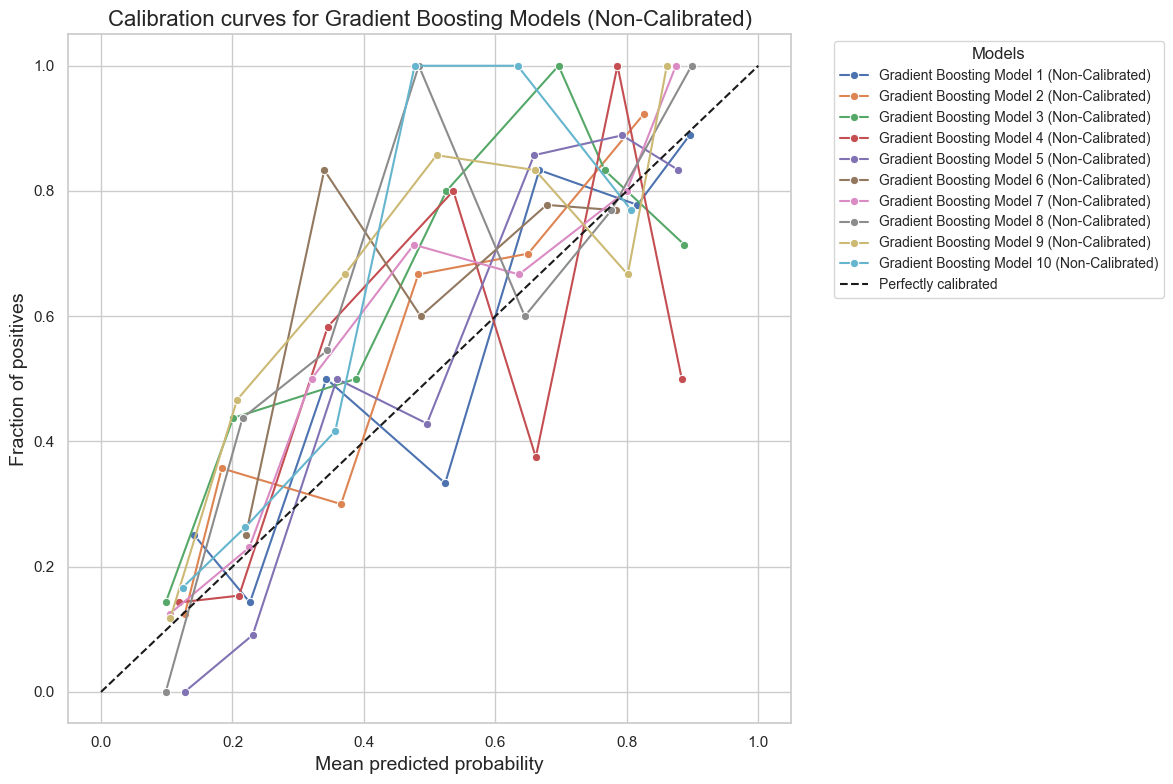

In [12]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('../XGBoost_Models/calibration_data_xgb.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=False)



## Extract feature importances and save them in a csv file

In [14]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='feature_importances.csv', 
                                                       model_name_prefix='gb', 
                                                       top_models_path='../XGBoost_Models/top_models_xgb.joblib')

Data saved to - feature_importances.csv


## Plot feature importance

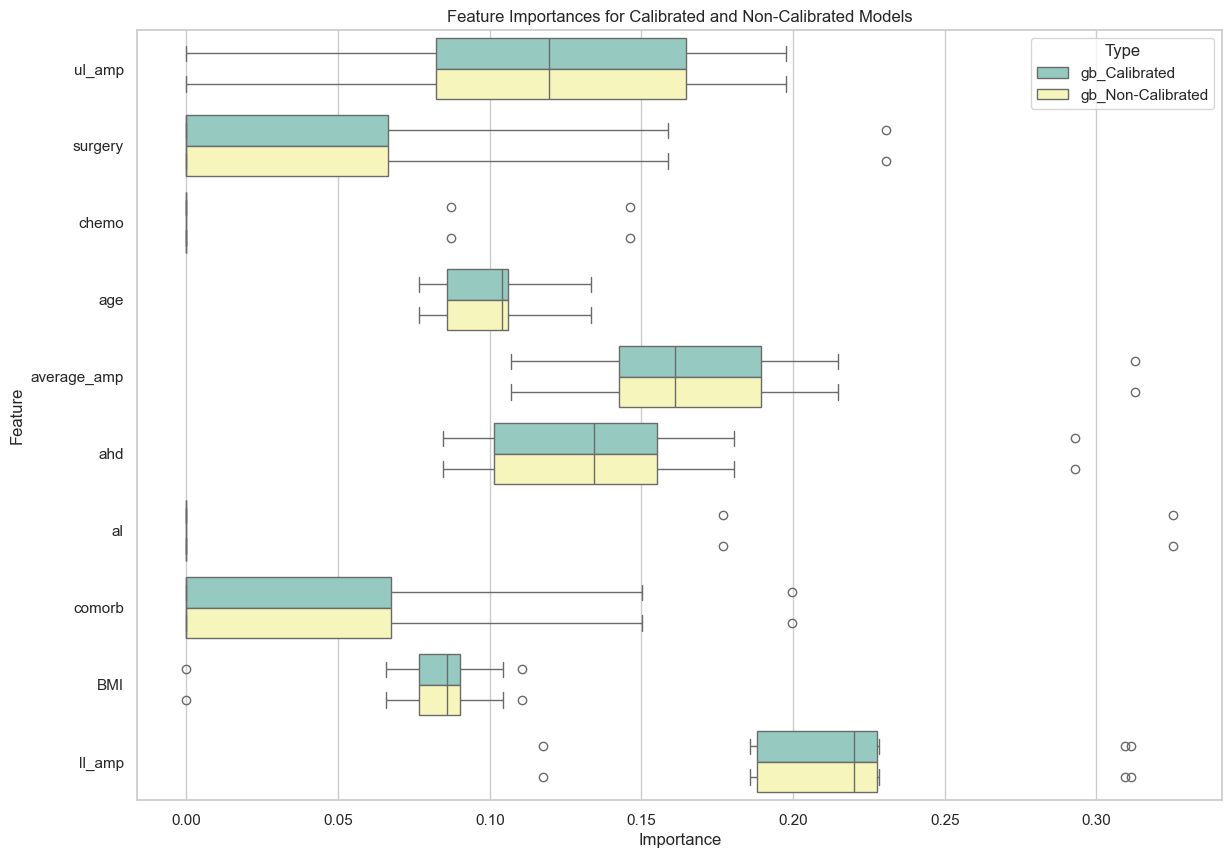

In [15]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [16]:
loaded_results = joblib.load('../XGBoost_Models/results.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.745852   0.792678  0.713625  0.743241  0.770260
std           0.021685   0.054986  0.101914  0.040549  0.017231
min           0.688525   0.674419  0.468750  0.625000  0.705819
max           0.819672   0.947368  0.937500  0.840580  0.822737
95% CI lower  0.703350   0.684906  0.513874  0.663765  0.736487
95% CI upper  0.788355   0.900450  0.913376  0.822718  0.804032

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.744639   0.792014  0.712000  0.741913  0.768584
std           0.021957   0.055644  0.102632  0.040452  0.018084
min           0.688525   0.652174  0.468750  0.612245  0.705280
max           0.803279   0.947368  0.968750  0.833333  0.820043
95% CI lower  0.701604   0.682950  0.510841  0.662628  0.733140
95% CI upper  0.787674   0.901077  0.913159  0.821199  0.804027


In [17]:
filename='../saved_models/final_results.csv'
model_name = 'XGB'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to ../saved_models/final_results.csv'

# Creating the ensemble model

In [24]:
load_models_info = joblib.load('../XGBoost_Models/top_models_xgb.joblib')

In [25]:
from sklearn.ensemble import VotingClassifier

def create_ensemble_model(top_models):
    """
    Create an ensemble model from the top 10 models using VotingClassifier.

    Parameters:
    top_models (list): List of dictionaries containing the top models information.

    Returns:
    VotingClassifier: An ensemble model created from the top 10 models.
    """
    # Create a list of tuples with model names and the actual models
    estimators = [(f'model_{i}', model_info['model_calibrated']) for i, model_info in enumerate(top_models)]

    # Create a voting classifier
    ensemble_model = VotingClassifier(estimators=estimators, voting='soft')

    return ensemble_model

In [27]:
ensemble_model = create_ensemble_model(load_models_info)

In [28]:
# Fit the ensemble model on the training data
ensemble_model.fit(X_t, y_t)

VotingClassifier(estimators=[('model_0',
                              CalibratedClassifierCV(cv=10,
                                                     estimator=Pipeline(steps=[('columntransformer',
                                                                                ColumnTransformer(transformers=[('num',
                                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                                  SimpleImputer()),
                                                                                                                                 ('scaler',
                                                                                                                                  StandardScaler())]),
                                                                                                                 ['age',
                                                                                                                  'BMI',
                                                                                                                  'ul_amp',
                                                                                                                  'll_amp',
                                                                                                                  'average_amp',
                                                                                                                  'ahd']),
                                                                                                                ('cat',
                                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                                  SimpleImputer(strategy='most_frequ...
                                                                                              importance_type=None,
                                                                                              interaction_constraints=None,
                                                                                              lambda=2.3804545796359973,
                                                                                              learning_rate=0.06791315226117131,
                                                                                              max_bin=None,
                                                                                              max_cat_threshold=None,
                                                                                              max_cat_to_onehot=None,
                                                                                              max_delta_step=None,
                                                                                              max_depth=5,
                                                                                              max_leaves=None,
                                                                                              min_child_weight=4,
                                                                                              missing=nan,
                                                                                              monotone_constraints=None,
                                                                                              multi_strategy=None,
                                                                                              n_estimators=158,
                                                                                              n_jobs=None, ...))]),
                                                     method='isotonic'))],


In [29]:
# Validate the ensemble model on the internal validation set
y_proba_ensemble = ensemble_model.predict_proba(X_int_val)[:, 1]
y_pred_ensemble = ensemble_model.predict(X_int_val)

# ROC curve and other metrics
fpr, tpr, thresholds = roc_curve(y_int_val, y_proba_ensemble)
roc_auc = auc(fpr, tpr)

# Evaluation metrics
accuracy = accuracy_score(y_int_val, y_pred_ensemble)
precision = precision_score(y_int_val, y_pred_ensemble)
recall = recall_score(y_int_val, y_pred_ensemble)
f1 = f1_score(y_int_val, y_pred_ensemble)
conf_matrix = confusion_matrix(y_int_val, y_pred_ensemble)
class_report = classification_report(y_int_val, y_pred_ensemble)

In [37]:
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.70      0.74      0.72        19

    accuracy                           0.77        47
   macro avg       0.76      0.76      0.76        47
weighted avg       0.77      0.77      0.77        47



In [38]:
print(f1)

0.717948717948718


# BOOTSTRAP SAMPLING & TRAINING

In [ ]:
# Initialize lists to store results
top_models = []
fraction_of_positives_calibrated_list = []
mean_predicted_value_calibrated_list = []
fraction_of_positives_non_calibrated_list = []
mean_predicted_value_non_calibrated_list = []
results = []
# Number of bins for more granularity
n_bins_non_calibrated = 6
n_bins_calibrated = 6
for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    # Non-calibrated model
    xgb_pipeline = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss'))
    xgb_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = xgb_pipeline.predict_proba(X_v)[:, 1]

    # Calibrated model
    best_xgb_pipeline = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss'))
    best_xgb_pipeline.fit(X_train_resampled, y_train_resampled)  # Fit the underlying pipeline first
    model = CalibratedClassifierCV(best_xgb_pipeline, method='isotonic', cv=10)
    model.fit(X_train_resampled, y_train_resampled)
    y_proba_calibrated = model.predict_proba(X_v)[:, 1]

    # Verify that the models are fitted
    try:
        check_is_fitted(xgb_pipeline.named_steps['xgbclassifier'])
    except NotFittedError:
        print(f"XGBClassifier in non-calibrated pipeline is not fitted. Skipping this model.")
        continue

    try:
        check_is_fitted(model)
    except NotFittedError:
        print(f"XGBClassifier is not fitted. Skipping this model.")
        continue

    # Calibration curves for non-calibrated model
    fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=n_bins_non_calibrated)
    if len(fraction_of_positives_non_calibrated) == n_bins_non_calibrated:
        print(f"FRACTION OF POSITIVE NON CALIBRATED: {fraction_of_positives_non_calibrated}")
        fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
        mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)
    else:
        print(f"Non-calibrated model - Unexpected number of bins: {len(fraction_of_positives_non_calibrated)}")

    # Calibration curves for calibrated model
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=n_bins_calibrated)
    if len(fraction_of_positives_calibrated) == n_bins_calibrated:
        print(f"FRACTION OF POSITIVE CALIBRATED: {fraction_of_positives_calibrated}")
        fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
        mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)
    else:
        print(f"Calibrated model - Unexpected number of bins: {len(fraction_of_positives_calibrated)}")

    # ROC curve and other metrics for calibrated model
    fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

    # ROC curve and other metrics for non-calibrated model
    fpr_non_calibrated, tpr_non_calibrated, thresholds_non_calibrated = roc_curve(y_v, y_proba_non_calibrated)
    roc_auc_non_calibrated = auc(fpr_non_calibrated, tpr_non_calibrated)
    optimal_idx_non_calibrated = np.argmax(tpr_non_calibrated - fpr_non_calibrated)
    optimal_threshold_non_calibrated = thresholds_non_calibrated[optimal_idx_non_calibrated]
    y_pred_optimal_non_calibrated = (y_proba_non_calibrated >= optimal_threshold_non_calibrated).astype(int)

    # Extract feature importances and names for non-calibrated model
    pipeline_non_calibrated = xgb_pipeline
    xgb_non_calibrated = pipeline_non_calibrated.named_steps['xgbclassifier']
    feature_importances_non_calibrated = xgb_non_calibrated.feature_importances_
    preprocessor = pipeline_non_calibrated.named_steps['columntransformer']
    feature_names = preprocessor.get_feature_names_out()

    # Aggregate importances for one-hot encoded features for non-calibrated model
    aggregated_importances_non_calibrated = defaultdict(float)
    for feature_name, importance in zip(feature_names, feature_importances_non_calibrated):
        original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
        aggregated_importances_non_calibrated[original_feature_name] += importance

    # Convert aggregated importances to a sorted list of tuples for non-calibrated model
    sorted_importances_non_calibrated = sorted(aggregated_importances_non_calibrated.items(), key=lambda x: x[1], reverse=True)

    # Extract feature importances and names for calibrated model
    pipeline_calibrated = model.estimator
    xgb_calibrated = pipeline_calibrated.named_steps['xgbclassifier']
    feature_importances_calibrated = xgb_calibrated.feature_importances_

    # Aggregate importances for one-hot encoded features for calibrated model
    aggregated_importances_calibrated = defaultdict(float)
    for feature_name, importance in zip(feature_names, feature_importances_calibrated):
        original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
        aggregated_importances_calibrated[original_feature_name] += importance

    # Convert aggregated importances to a sorted list of tuples for calibrated model
    sorted_importances_calibrated = sorted(aggregated_importances_calibrated.items(), key=lambda x: x[1], reverse=True)

    model_info = {
        'model_calibrated': model,
        'fpr_calibrated': fpr,
        'tpr_calibrated': tpr,
        'thresholds_calibrated': thresholds,
        'roc_auc_calibrated': roc_auc,
        'optimal_threshold_calibrated': optimal_threshold,
        'accuracy_calibrated': accuracy_score(y_v, y_pred_optimal),
        'precision_calibrated': precision_score(y_v, y_pred_optimal),
        'recall_calibrated': recall_score(y_v, y_pred_optimal),
        'f1_score_calibrated': f1_score(y_v, y_pred_optimal),
        'confusion_matrix_calibrated': confusion_matrix(y_v, y_pred_optimal),
        'classification_report_calibrated': classification_report(y_v, y_pred_optimal),
        'feature_importances_calibrated': sorted_importances_calibrated,
        'model_non_calibrated': xgb_pipeline,
        'fpr_non_calibrated': fpr_non_calibrated,
        'tpr_non_calibrated': tpr_non_calibrated,
        'thresholds_non_calibrated': thresholds_non_calibrated,
        'roc_auc_non_calibrated': roc_auc_non_calibrated,
        'optimal_threshold_non_calibrated': optimal_threshold_non_calibrated,
        'accuracy_non_calibrated': accuracy_score(y_v, y_pred_optimal_non_calibrated),
        'precision_non_calibrated': precision_score(y_v, y_pred_optimal_non_calibrated),
        'recall_non_calibrated': recall_score(y_v, y_pred_optimal_non_calibrated),
        'f1_score_non_calibrated': f1_score(y_v, y_pred_optimal_non_calibrated),
        'confusion_matrix_non_calibrated': confusion_matrix(y_v, y_pred_optimal_non_calibrated),
        'classification_report_non_calibrated': classification_report(y_v, y_pred_optimal_non_calibrated),
        'feature_importances_non_calibrated': sorted_importances_non_calibrated
    }

    # Add the non-model info to results
    model_info_without_model = {key: value for key, value in model_info.items() if not key.startswith('model')}
    results.append(model_info_without_model)

    # Keep top 10 models based on calibrated ROC AUC
    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc_calibrated'], top_models[x]['recall_calibrated']))
        if roc_auc > top_models[min_index]['roc_auc_calibrated']:
            top_models[min_index] = model_info
    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")



In [ ]:
joblib.dump(top_models, 'top_models_with_importances.joblib')
joblib.dump(results, 'results.joblib')

In [ ]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Separate metrics for calibrated and non-calibrated models
calibrated_metrics = df_results[['accuracy_calibrated', 'precision_calibrated', 'recall_calibrated', 'f1_score_calibrated', 'roc_auc_calibrated']]
non_calibrated_metrics = df_results[['accuracy_non_calibrated', 'precision_non_calibrated', 'recall_non_calibrated', 'f1_score_non_calibrated', 'roc_auc_non_calibrated']]

# Calculate summary statistics for calibrated metrics
calibrated_summary = calibrated_metrics.agg(['mean', 'std', 'min', 'max'])
calibrated_summary.loc['95% CI lower'] = calibrated_summary.loc['mean'] - 1.96 * calibrated_summary.loc['std']
calibrated_summary.loc['95% CI upper'] = calibrated_summary.loc['mean'] + 1.96 * calibrated_summary.loc['std']

# Calculate summary statistics for non-calibrated metrics
non_calibrated_summary = non_calibrated_metrics.agg(['mean', 'std', 'min', 'max'])
non_calibrated_summary.loc['95% CI lower'] = non_calibrated_summary.loc['mean'] - 1.96 * non_calibrated_summary.loc['std']
non_calibrated_summary.loc['95% CI upper'] = non_calibrated_summary.loc['mean'] + 1.96 * non_calibrated_summary.loc['std']

# Rename columns for clarity
calibrated_summary.columns = [col.replace('_calibrated', '') for col in calibrated_summary.columns]
non_calibrated_summary.columns = [col.replace('_non_calibrated', '') for col in non_calibrated_summary.columns]

# Print the summaries
print("Calibrated Model Metrics Summary")
print(calibrated_summary)

print("\nNon-Calibrated Model Metrics Summary")
print(non_calibrated_summary)

# Optionally, save these summaries to CSV for further analysis or reporting
calibrated_summary.to_csv('calibrated_model_metrics_summary.csv')
non_calibrated_summary.to_csv('non_calibrated_model_metrics_summary.csv')

In [ ]:
calibrated_summary, non_calibrated_summary = bs_results.get_results(results)

In [ ]:
# Example usage
filename='../saved_models/final_results.csv'
model_name = 'xgb'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

In [ ]:
# Verify the calibration lists before calculating the means
print(f"Number of calibrated entries: {len(fraction_of_positives_calibrated_list)}")
print(f"Number of non-calibrated entries: {len(fraction_of_positives_non_calibrated_list)}")

# Calculate the mean fraction of positives and mean predicted values for calibrated models
mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)

# Calculate the mean fraction of positives and mean predicted values for non-calibrated models
mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# Debugging: print the means
print(f"Calibrated mean fraction of positives: {mean_fraction_of_positives_calibrated}")
print(f"Calibrated mean predicted value: {mean_mean_predicted_value_calibrated}")
print(f"Non-calibrated mean fraction of positives: {mean_fraction_of_positives_non_calibrated}")
print(f"Non-calibrated mean predicted value: {mean_mean_predicted_value_non_calibrated}")

# Interpolate to a common set of points for smoother comparison
common_points = np.linspace(0, 1, 100)
interp_fraction_of_positives_calibrated = np.interp(common_points, mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated)
interp_fraction_of_positives_non_calibrated = np.interp(common_points, mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated)

# Plot the calibration curves
plt.figure(figsize=[8, 6])
plt.plot(common_points, interp_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(common_points, interp_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping")
plt.legend()
plt.show()

In [ ]:
top_models = []
fraction_of_positives_calibrated_list = []
mean_predicted_value_calibrated_list = []
fraction_of_positives_non_calibrated_list = []
mean_predicted_value_non_calibrated_list = []
results = []

for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    xgb_pipeline = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss'))
    xgb_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = xgb_pipeline.predict_proba(X_v)[:, 1]

    best_xgb_pipeline = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss'))
    model = CalibratedClassifierCV(best_xgb_pipeline, method='sigmoid', cv=10)
    model.fit(X_train_resampled, y_train_resampled)
    y_proba_calibrated = model.predict_proba(X_v)[:, 1]

    fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=6)
    if len(fraction_of_positives_non_calibrated) == 6:
        fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
        mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)

    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=6)
    if len(fraction_of_positives_calibrated) == 6:
        fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
        mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)

    fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

    model_info = {
        'model': model,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy_score(y_v, y_pred_optimal),
        'precision': precision_score(y_v, y_pred_optimal),
        'recall': recall_score(y_v, y_pred_optimal),
        'f1_score': f1_score(y_v, y_pred_optimal),
        'confusion_matrix': confusion_matrix(y_v, y_pred_optimal),
        'classification_report': classification_report(y_v, y_pred_optimal)
    }

    model_info_without_model = {key: value for key, value in model_info.items() if key != 'model'}
    results.append(model_info_without_model)

    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc'], top_models[x]['recall']))
        if roc_auc > top_models[min_index]['roc_auc']:
            top_models[min_index] = model_info

    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")

In [ ]:
# Calculate the mean calibration curve

mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)
mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# Plot the calibration curves
plt.figure(figsize=[8, 6])
plt.plot(mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping")
plt.legend()
plt.show()

In [ ]:
# Generate more points for a smoother curve
xnew = np.linspace(0, 1, 50)

# Smoothing spline for calibrated curve
spl_calibrated = make_interp_spline(mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated, k=3)
smooth_fraction_of_positives_calibrated = spl_calibrated(xnew)

# Smoothing spline for non-calibrated curve
spl_non_calibrated = make_interp_spline(mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated, k=3)
smooth_fraction_of_positives_non_calibrated = spl_non_calibrated(xnew)

# Plot the smoothed calibration curves
plt.figure(figsize=[8, 6])
plt.plot(xnew, smooth_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(xnew, smooth_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping with Smoothing")
plt.legend()
plt.show()


In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average
window_size = 2  # Choose a window size
smooth_fraction_of_positives_calibrated = moving_average(mean_fraction_of_positives_calibrated, window_size)
smooth_mean_predicted_value_calibrated = moving_average(mean_mean_predicted_value_calibrated, window_size)
smooth_fraction_of_positives_non_calibrated = moving_average(mean_fraction_of_positives_non_calibrated, window_size)
smooth_mean_predicted_value_non_calibrated = moving_average(mean_mean_predicted_value_non_calibrated, window_size)

# Plot the smoothed calibration curves
plt.figure(figsize=[8, 6])
plt.plot(smooth_mean_predicted_value_calibrated, smooth_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(smooth_mean_predicted_value_non_calibrated, smooth_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping with Moving Average")
plt.legend()
plt.show()

In [ ]:
# Apply LOWESS smoothing
smoothed_calibrated = lowess(mean_fraction_of_positives_calibrated, mean_mean_predicted_value_calibrated, frac=0.7)
smoothed_non_calibrated = lowess(mean_fraction_of_positives_non_calibrated, mean_mean_predicted_value_non_calibrated, frac=0.7)

# Extract the smoothed values
smooth_mean_predicted_value_calibrated, smooth_fraction_of_positives_calibrated = smoothed_calibrated[:,0], smoothed_calibrated[:,1]
smooth_mean_predicted_value_non_calibrated, smooth_fraction_of_positives_non_calibrated = smoothed_non_calibrated[:,0], smoothed_non_calibrated[:,1]

# Plot the smoothed calibration curves
plt.figure(figsize=[8, 6])
plt.plot(smooth_mean_predicted_value_calibrated, smooth_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(smooth_mean_predicted_value_non_calibrated, smooth_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping with LOWESS Smoothing")
plt.legend()
plt.show()


# RESULTS

In [ ]:
# RESULTS
df_results = pd.DataFrame(results)

metric_summary = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].agg(['mean', 'std', 'min', 'max'])
metric_summary.loc['95% CI lower'] = metric_summary.loc['mean'] - 1.96 * metric_summary.loc['std']
metric_summary.loc['95% CI upper'] = metric_summary.loc['mean'] + 1.96 * metric_summary.loc['std']

print(metric_summary)

# SAVING TOP 10 MODELS

In [ ]:
model_folder_path = '../saved_models/one_day_xgb_top10_new'

if os.path.exists(model_folder_path):
    shutil.rmtree(model_folder_path)
os.makedirs(model_folder_path)

for i, m in enumerate(top_models):
    model_path = os.path.join(model_folder_path, f'top_model_{i+1}.joblib')
    joblib.dump(m['model'], model_path)

preprocessor_path = os.path.join(model_folder_path, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)

print(f"All top models have been saved to folder: {model_folder_path}")
print(f"Preprocessor has been saved as {preprocessor_path}")

# CREATING ENSEMBLE MODEL

In [ ]:

class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

joblib_file = '../saved_models/one_day_xgb_top10_new/ensemble_classifier_xgb.joblib'
joblib.dump(ensemble_classifier, joblib_file)


# Load the ensemble classifier from a .joblib file

In [ ]:

ensemble_classifier = joblib.load(joblib_file)
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

# CALIBRATING THE ENSEMBLE MODEL

In [ ]:
# class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, models):
#         self.models = models
#         self.calibrator = None
    
#     def fit(self, X, y):
#         return self
    
#     def predict_proba(self, X):
#         probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
#         if self.calibrator:
#             probabilities = self.calibrator.transform(probabilities)
#         return probabilities
    
#     def predict(self, X):
#         probabilities = self.predict_proba(X)
#         predictions = (probabilities >= 0.5).astype(int)
#         return predictions
    
#     def calibrate(self, X, y):
#         probabilities = self.predict_proba(X)
#         self.calibrator = IsotonicRegression(out_of_bounds='clip')
#         self.calibrator.fit(probabilities, y)
#         return self

# ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
# ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

# # Save the ensemble classifier before calibration
# joblib_file = '../saved_models/one_day_xgb_top10/ensemble_classifier_xgb.joblib'
# joblib.dump(ensemble_classifier, joblib_file)

# # Calibrate the ensemble classifier on the prospective internal validation data
# ensemble_classifier.calibrate(X_int_val, y_int_val)

# # Save the calibrated ensemble classifier
# joblib_file_calibrated = '../saved_models/one_day_xgb_top10/calibrated_ensemble_classifier_xgb.joblib'
# joblib.dump(ensemble_classifier, joblib_file_calibrated)

# Now we can use the calibrated ensemble classifier to make predictions

In [ ]:
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

# Evaluate the ensemble performance on prospective data as needed
print("Calibrated Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Calibrated Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Calibrated Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Calibrated Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Calibrated Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba[:,1]))

# CALIBRATING THE ENSEMBLE MODEL - UPDATE

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.isotonic import IsotonicRegression

class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
        self.calibrator = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        if self.calibrator:
            probabilities = self.calibrator.transform(probabilities)
        return np.vstack([1 - probabilities, probabilities]).T  # Ensure correct shape for predict_proba

    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        predictions = (probabilities >= 0.5).astype(int)
        return predictions

    def calibrate(self, X, y):
        probabilities = self.predict_proba(X)[:, 1]
        self.calibrator = IsotonicRegression(out_of_bounds='clip')
        self.calibrator.fit(probabilities, y)
        return self


In [ ]:
# Define the ensemble models
ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]

# Instantiate the classifier
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

# Fit the classifier (assuming X_train and y_train are your training data)
ensemble_classifier.fit(X, y)

# Save the ensemble classifier before calibration
joblib_file = '../saved_models/one_day_xgb_top10/ensemble_classifier_xgb.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Calibrate the ensemble classifier on the prospective internal validation data
ensemble_classifier.calibrate(X_int_val, y_int_val)

# Save the calibrated ensemble classifier
joblib_file_calibrated = '../saved_models/one_day_xgb_top10/calibrated_ensemble_classifier_xgb.joblib'
joblib.dump(ensemble_classifier, joblib_file_calibrated)


# Result for Publication

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

In [ ]:
joblib_file = '../saved_models/one_day_xgb_top10/ensemble_classifier_xgb.joblib'
ensemble_classifier = joblib.load(joblib_file)

In [ ]:
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

In [ ]:
# Create a DataFrame with actual outcomes and predicted probabilities
results_df = pd.DataFrame({
    'actual_outcome': y_int_val,
    'predicted_probability': y_proba
})

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('../saved_models/one_day_xgb_top10/xgb_predictions.csv', index=False)
